In [14]:
import numpy as np
from iminuit import Minuit
from scipy.integrate import quad

from iminuit import Minuit

import constants, functions

import math

n_panth = 1701
cov_mat = np.array(constants.cov_mat).reshape(n_panth, n_panth)
inv_cov = np.linalg.inv(cov_mat)

def H_LCDM(z, H0, omega_m):
    return H0 * np.sqrt(omega_m * (1+z)**3 + (1 - omega_m))

def dL(z, H0, omega_m):
    c = constants.C
    integral, _ = quad(lambda zp: 1.0 / H_LCDM(zp, H0, omega_m), 0, z)
    return (1 + z) * c * integral

def mu(z, omega, H0):
    return 5 * np.log10(dL(z, H0, omega)) + 25

def chi2_panth(omega, H0, M):
    delta_mu = np.empty(n_panth)

    for i in range(n_panth):
        if constants.is_calibrator_panth[i] == 0:
            delta_mu[i] = mu(constants.z_data_panth[i], omega, H0) - (constants.m_b_corr_panth[i] - M)
        else:
            delta_mu[i] = constants.m_b_corr_panth[i] - M - constants.ceph_dist_panth[i]

    return delta_mu @ inv_cov @ delta_mu

def chi2_rsd(omega, sigma, gamma):
    model = functions.growth(constants.z_data, gamma=gamma, omega_0=omega, sigma_8_0=sigma)

    errors = np.asarray(0.5 * (constants.fs8_err_plus + constants.fs8_err_minus))
    residuals = (model - constants.fs8_data.values) / errors
    return np.sum(residuals**2)

def chi2tot(omega, sigma, gamma, H0, M):
    # return chi2_panth(omega, H0, M)
    return chi2_rsd(omega, sigma, gamma) + chi2_panth(omega, H0, M)

In [15]:
n_om = 100
om_min = .05
om_max = 1

n_s8 = 100
s8_min = 0.4
s8_max = 1.2

n_gamma = 100
gamma_min = -0.5
gamma_max = 2

omega_vals = np.asarray(np.linspace(om_min, om_max, n_om))
sigma_vals = np.asarray(np.linspace(s8_min, s8_max, n_s8))
gamma_vals = np.asarray(np.linspace(gamma_min, gamma_max, n_gamma))

minimizer = Minuit(chi2tot, omega=0.315, sigma=0.811, gamma=0.55, H0 = 73.4, M=-19.25)

minimizer.limits["omega"] = (om_min,om_max)
minimizer.limits["sigma"] = (s8_min,s8_max)
minimizer.limits["gamma"] = (gamma_min,gamma_max)
minimizer.limits["H0"] = (0, 200)
minimizer.fixed["M"] = True

result = minimizer.migrad()

In [16]:
print(f"\nRésultats du fit :")
print(f"Chi2 = {minimizer.fval:.2f} \n")
print(f"Paramètres estimés :")
print(f"Ωm = {minimizer.values['omega']:.10f} ± {minimizer.errors['omega']:.10f}")
print(f"σ8,0 = {minimizer.values['sigma']:.10f} ± {minimizer.errors['sigma']:.10f}")
print(f"γ = {minimizer.values['gamma']:.10f} ± {minimizer.errors['gamma']:.10f}\n")
print(f"H0 = {minimizer.values['H0']:.10f} ± {minimizer.errors['H0']:.10f}")
print(f"M = {minimizer.values['M']:.10f} ± {minimizer.errors['M']:.10f}")

print(result)


Résultats du fit :
Chi2 = 1592.27 

Paramètres estimés :
Ωm = 0.3527096773 ± 0.0185702486
σ8,0 = 0.7546689729 ± 0.0477977060
γ = 0.5464512238 ± 0.1257045177

H0 = 72.8418987513 ± 0.2328997390
M = -19.2500000000 ± 0.1925000000
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1592                       │              Nfcn = 100              │
│ EDM = 3.15e-07 (Goal: 0.0002)    │            time = 3.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│            

chi2 théorie        : 14.999544577468223
chi2 RSD seul       : 8.055740706979694
chi2 RSD + Pantheon : 9.97229829420518


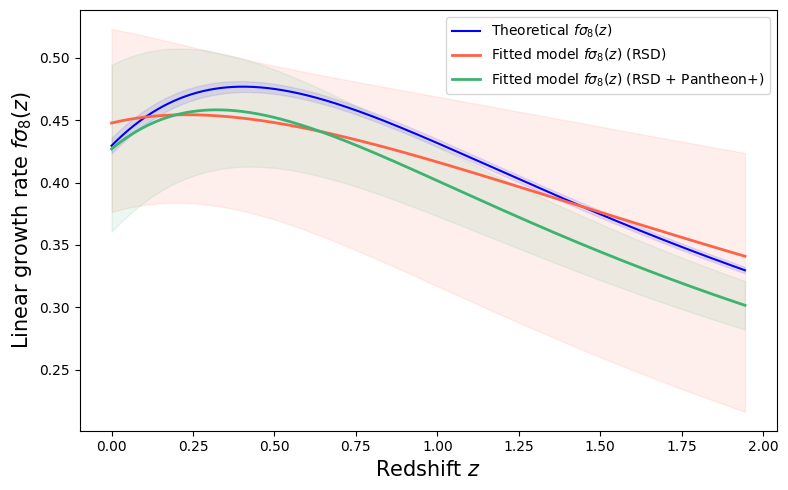

In [57]:
from scipy.stats import chi2
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt

################################ Number of points for theoretical growth function plot
nb_points_th = 1000
z_range = np.linspace(min(constants.z_data), max(constants.z_data), nb_points_th)

################################ Bootstrap

### Theoretical
nb_draw = 1000
fsigma8_results_boot = np.zeros((nb_draw, nb_points_th))

for i in range(nb_draw):
    omega0 = np.random.normal(constants.OMEGA_0, constants.OMEGA_0_SIGMA)
    sigma8_0 = np.random.normal(constants.SIGMA_8_0, constants.SIGMA_8_0_SIGMA)
    fsigma8_results_boot[i, :] = functions.growth(z_range, omega_0 = omega0, sigma_8_0 = sigma8_0)

fsigma8_mean, fsigma8_std = np.mean(fsigma8_results_boot, axis=0), np.std(fsigma8_results_boot, axis=0)

### RSD
fsigma8_rsd_boot = np.zeros((nb_draw, nb_points_th))

for i in range(nb_draw):
    omega0 = np.random.normal(0.050, 0.1162)
    while omega0 < 0:
        omega0 = np.random.normal(0.050, 0.1162)
    sigma8_0 = np.random.normal(0.536, 0.0553)
    gamma = np.random.normal(0.060, 0.051)
    while gamma < 0:
        gamma = np.random.normal(0.060, 0.051)
    fsigma8_rsd_boot[i, :] = functions.growth(z_range, omega_0=omega0, sigma_8_0=sigma8_0, gamma=gamma)

fsigma8_rsd_mean, fsigma8_rsd_std = np.mean(fsigma8_rsd_boot, axis=0), np.std(fsigma8_rsd_boot, axis=0)

### RSD + Pantheon+
fsigma8_rsd_panth_boot = np.zeros((nb_draw, nb_points_th))

for i in range(nb_draw):
    omega0 = np.random.normal(0.352, 0.0185702486)
    sigma8_0 = np.random.normal(0.755, 0.0477977060)
    gamma = np.random.normal(0.546, 0.1257045177)
    fsigma8_rsd_panth_boot[i, :] = functions.growth(z_range, omega_0=omega0, sigma_8_0=sigma8_0, gamma=gamma)

fsigma8_rsd_panth_mean, fsigma8_rsd_panth_std = np.mean(fsigma8_rsd_panth_boot, axis=0), np.std(fsigma8_rsd_panth_boot, axis=0)

################################ Approximation

fs8_approx_rsd = functions.growth(z_range, gamma=0.060, omega_0=0.050, sigma_8_0=0.536)
fs8_approx_rsd_panth = functions.growth(z_range, gamma=0.5464512238, omega_0=0.3527096773, sigma_8_0=0.7546689729)

################################ Plotting

plt.figure(figsize=(8, 5))

def chi2_abs(z_data, data, fs8_err_asym, model_func):
    # Calculer les erreurs symétriques moyennes
    err = 0.5 * (np.array(fs8_err_asym[0]) + np.array(fs8_err_asym[1]))

    model_vals = model_func(z_data)
    model_vals = np.asarray(model_vals)

    if model_vals.shape != data.shape:
        raise ValueError(f"Incompatible shapes: model {model_vals.shape} vs data {data.shape}")

    residuals = (data - model_vals) / err
    return np.sum(residuals**2)



growth_values = functions.growth(z_range)
plt.plot(z_range, growth_values, color='blue', label=r"Theoretical $f\sigma_8(z)$")
plt.fill_between(z_range, fsigma8_mean-fsigma8_std,
                            fsigma8_mean+fsigma8_std,
                color='blue', alpha=0.1)

plt.plot(z_range, fs8_approx_rsd, color='tomato', lw=2, label=r"Fitted model $f\sigma_8(z)$ (RSD)")
plt.fill_between(z_range, fsigma8_rsd_mean - fsigma8_rsd_std,
                             fsigma8_rsd_mean + fsigma8_rsd_std,
                 color='tomato', alpha=0.1)

plt.plot(z_range, fs8_approx_rsd_panth, color='mediumseagreen', lw=2, label=r"Fitted model $f\sigma_8(z)$ (RSD + Pantheon+)")
plt.fill_between(z_range, fsigma8_rsd_panth_mean - fsigma8_rsd_panth_std,
                             fsigma8_rsd_panth_mean + fsigma8_rsd_panth_std,
                 color='mediumseagreen', alpha=0.1)

# Labels
plt.xlabel("Redshift $z$", fontsize=15)
plt.ylabel(r"Linear growth rate $f\sigma_8(z)$", fontsize=15)
plt.grid(False)
plt.legend()
plt.tight_layout()

chi2_theory = chi2_abs(constants.z_data, constants.fs8_data, constants.fs8_err, functions.growth)
chi2_rsd = chi2_abs(constants.z_data, constants.fs8_data, constants.fs8_err,
                lambda x: functions.growth(x, gamma=0.060, omega_0=0.050, sigma_8_0=0.536))
chi2_rsd_panth = chi2_abs(constants.z_data, constants.fs8_data, constants.fs8_err,
                lambda x: functions.growth(x, gamma=0.546, omega_0=0.352, sigma_8_0=0.755))
print("chi2 théorie        :", chi2_theory)
print("chi2 RSD seul       :", chi2_rsd)
print("chi2 RSD + Pantheon :", chi2_rsd_panth)


plt.show()